# Segmenting Micrographs Using the Louvain method for Community Detection  (Part I) #

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial.distance import pdist, squareform
from sknetwork.clustering import Louvain
import networkx as nx
import cv2

import igraph as ig
import louvain
from data_tools import read_chip_database

/tmp/ipykernel_5428/585059292.py:11: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain
2024-05-31 15:38:48.388574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 15:38:54.718838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Formatting ##
It is best practice to collect data for samples in a Hierarchical Data Format 5 (HDF5) file. This format is chosen since it is capable of storing large amounts of data for each sample. This notebook assumes that this format is used to store all experimental data. As an example, we will be looking at a micrograph of a lanthanum iron oxide (LFO) sample with 0.1 dpa (displacements per atom) of irradiation damage.

In [2]:
# path to desired h5 file
h5_path = 'data.h5'
print(h5_path)

# name of sample/title you want to use for storing data
name = '0.1 dpa LFO Pristine'
print(name)

# path to folder where final results will be stored
results_path = 'results'
print(results_path)

/qfs/people/terp379/multimodal_few_shot/public/data.h5
0.1 dpa LFO Pristine
/qfs/people/terp379/multimodal_few_shot/public/results


In [3]:
# display h5 database as a pandas dataframe to make sure data is appropriately formatted and ease of access
data = read_chip_database(h5_path)
data.head()

,chip ID,atom percent data,eds spectra,image data,image encoding data
0,R0C0,"[0.6700455405858518, 23.560929009938608, 34.97...","[5, 3, 6, 1, 3, 7, 3, 3, 2, 5, 2, 4, 2, 3, 1, ...","[251, 251, 251, 243, 243, 243, 252, 252, 252, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,R0C1,"[0.0, 25.13870666576139, 39.4564045784213, 2.7...","[5, 4, 3, 3, 4, 5, 3, 6, 4, 3, 1, 5, 3, 4, 3, ...","[250, 250, 250, 241, 241, 241, 250, 250, 250, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,R0C10,"[0.9446672398372494, 21.04423101076837, 32.699...","[0, 1, 2, 1, 2, 2, 2, 4, 2, 3, 3, 1, 4, 2, 0, ...","[204, 204, 204, 172, 172, 172, 196, 196, 196, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,R0C11,"[0.0, 16.810135159673173, 37.92829811409133, 4...","[3, 3, 0, 3, 2, 4, 2, 4, 1, 1, 3, 2, 2, 3, 0, ...","[218, 218, 218, 237, 237, 237, 239, 239, 239, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,R0C12,"[0.0, 23.414314543926327, 32.370411655494, 7.5...","[4, 1, 4, 3, 4, 3, 2, 3, 4, 3, 3, 3, 4, 0, 3, ...","[229, 229, 229, 246, 246, 246, 238, 238, 238, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
# list all columns (except 'chip ID') as imaging modalities
modalities = list(data.columns[1: ])
modalities

['atom percent data', 'eds spectra', 'image data', 'image encoding data']

In [5]:
# convert chip ids formatted 'R{i}C{j}' to a sequence of number ids from 0 to (n*m)-1 where n is the number of rows 
# and m is the number of columns
m = sum(data["chip ID"].str.count("R\d+C0"))
n = sum(data["chip ID"].str.count("R0C\d+"))
print("Number of rows: ", m)
print("Number of columns: ", n)
d = {}

_ = 0
for i in range(m):
    for j in range(n):
        d["R" + str(i) + "C" + str(j)] = _
        _ += 1
        
inv_d = {v: k for k, v in d.items()}

Number of rows:  24
Number of columns:  24


In [6]:
# rename the indices of data using the new convention defined above and display to ensure correctness
data = data.replace({"chip ID": d}).sort_values(by=['chip ID']).replace({"chip ID": inv_d})
data.head()

,chip ID,atom percent data,eds spectra,image data,image encoding data
0,R0C0,"[0.6700455405858518, 23.560929009938608, 34.97...","[5, 3, 6, 1, 3, 7, 3, 3, 2, 5, 2, 4, 2, 3, 1, ...","[251, 251, 251, 243, 243, 243, 252, 252, 252, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,R0C1,"[0.0, 25.13870666576139, 39.4564045784213, 2.7...","[5, 4, 3, 3, 4, 5, 3, 6, 4, 3, 1, 5, 3, 4, 3, ...","[250, 250, 250, 241, 241, 241, 250, 250, 250, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12,R0C2,"[0.0, 18.794121536322397, 37.76444011272184, 2...","[3, 5, 2, 4, 2, 4, 6, 5, 0, 1, 2, 2, 4, 1, 3, ...","[249, 249, 249, 243, 243, 243, 246, 246, 246, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17,R0C3,"[0.4223305458571545, 21.942633798469235, 43.73...","[6, 5, 4, 3, 3, 3, 4, 3, 4, 2, 4, 3, 2, 5, 1, ...","[255, 255, 255, 246, 246, 246, 236, 236, 236, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,R0C4,"[0.0, 17.7790334543804, 28.90547565759204, 3.2...","[1, 1, 1, 1, 1, 5, 0, 3, 2, 2, 1, 3, 3, 3, 0, ...","[219, 219, 219, 248, 248, 248, 238, 238, 238, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Computing Similarities ##
In order to cluster the image features, we need to define a metric which quantifies the similarities of image chips. Computing the pairwise cosine similarity scores is one way to accomplish this. The scores will be bounded by the interval $[0, 1]$. The scores are directly proportional to the similarity of the chip pair.

In [7]:
# compute the similarity scores for each modality and store results in a dictionary
similarities = {}
for modality in modalities:
    similarities[modality] = 1 - pdist(np.stack(data[modality].values), metric="cosine")

## Visualizing Similarity Distributions ##
It is helpful to visualize the distribution of these similarity scores as they can vary widely based on the modality studied.

In [8]:
# determine the number of bins for the similarity score distributions
num_bins = 100

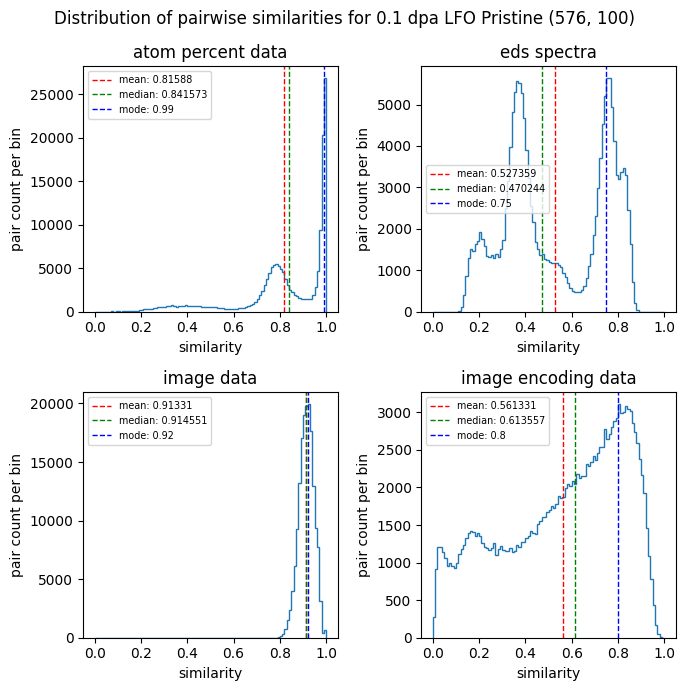

In [9]:
### need to generalize to any number of modalities (can only do up to 4 now) ###
# plot the similarity score distributions for each modality
counts = {}
bins = {}
statistics = {}
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
# fig.tight_layout()
title = "Distribution of pairwise similarities for " + name  + " (" + str(data.shape[0]) + ", " + str(num_bins) + ")"
fig.suptitle(title)
coordinates = [(r, c) for r in np.arange(2) for c in np.arange(2)]
_ = 0
for modality in modalities:
    
    axs[coordinates[_]].set_title(modality)
    
    c, b = np.histogram(similarities[modality], bins=np.arange(0, 1 + (1 / num_bins), 1 / num_bins))
    
    mean = np.mean(similarities[modality])
    median = np.median(similarities[modality])
    mode = b[np.argmax(c)]
    
    rounded_mean = np.round(mean, decimals=6)
    rounded_median = np.round(median, decimals=6)
    rounded_mode = np.round(mode, decimals=6)
    
    counts[modality] = c
    bins[modality]  = b
    statistics[modality] = {"mean": mean, "median": median, "mode": mode}
    
    axs[coordinates[_]].axvline(rounded_mean, color='r', linestyle='dashed', linewidth=1, label='mean: ' + str(rounded_mean))
    axs[coordinates[_]].axvline(rounded_median, color='g', linestyle='dashed', linewidth=1, label='median: ' + str(rounded_median))
    axs[coordinates[_]].axvline(rounded_mode, color='b', linestyle='dashed', linewidth=1, label='mode: ' + str(rounded_mode))
    
    axs[coordinates[_]].stairs(c, b)     
    axs[coordinates[_]].set_xlabel("similarity")
    axs[coordinates[_]].set_ylabel("pair count per bin")
    axs[coordinates[_]].legend(fontsize='x-small')
    
    _ += 1
plt.tight_layout()
fig.savefig(os.path.join(results_path, name + "_similarities_dist.png"))

In [10]:
### computes redundant similarity scores since modality x + y = y + x ###
# compute the unweighted average, binwise average, and pairwise average similarity scores for each combination of modalities and store results in a dictionary
similarities2 = {}
for modality in modalities:
    for modality2 in modalities:
        if modality != modality2:
            similarities2[modality + " and " + modality2] = {}
            
            similarities2[modality + " and " + modality2]["unweighted average"] = (similarities[modality] + similarities[modality2]) / 2
            
            weights = counts[modality] / (counts[modality] + counts[modality2])
            weights2 = counts[modality2] / (counts[modality] + counts[modality2])
            similarities2[modality + " and " + modality2]["binwise average"] = (weights[np.digitize(similarities[modality], bins=bins[modality], right=True) - 1] * similarities[modality]) + (weights2[np.digitize(similarities[modality2], bins=bins[modality2], right=True) - 1] * similarities[modality2])
            similarities2[modality + " and " + modality2]["binwise average"] = (similarities2[modality + " and " + modality2]["binwise average"] - min(similarities2[modality + " and " + modality2]["binwise average"])) / (max(similarities2[modality + " and " + modality2]["binwise average"]) - min(similarities2[modality + " and " + modality2]["binwise average"]))
            
            weights = counts[modality][np.digitize(similarities[modality], bins=bins[modality], right=True) - 1] / (counts[modality][np.digitize(similarities[modality], bins=bins[modality], right=True) - 1] + counts[modality2][np.digitize(similarities[modality2], bins=bins[modality2], right=True) - 1])
            weights2 = counts[modality2][np.digitize(similarities[modality2], bins=bins[modality2], right=True) - 1] / (counts[modality][np.digitize(similarities[modality], bins=bins[modality], right=True) - 1] + counts[modality2][np.digitize(similarities[modality2], bins=bins[modality2], right=True) - 1])
            similarities2[modality + " and " + modality2]["pairwise average"] = (weights * similarities[modality]) + (weights2 * similarities[modality2])

/tmp/ipykernel_5428/599167310.py:11: RuntimeWarning: invalid value encountered in divide
  weights = counts[modality] / (counts[modality] + counts[modality2])
/tmp/ipykernel_5428/599167310.py:12: RuntimeWarning: invalid value encountered in divide
  weights2 = counts[modality2] / (counts[modality] + counts[modality2])


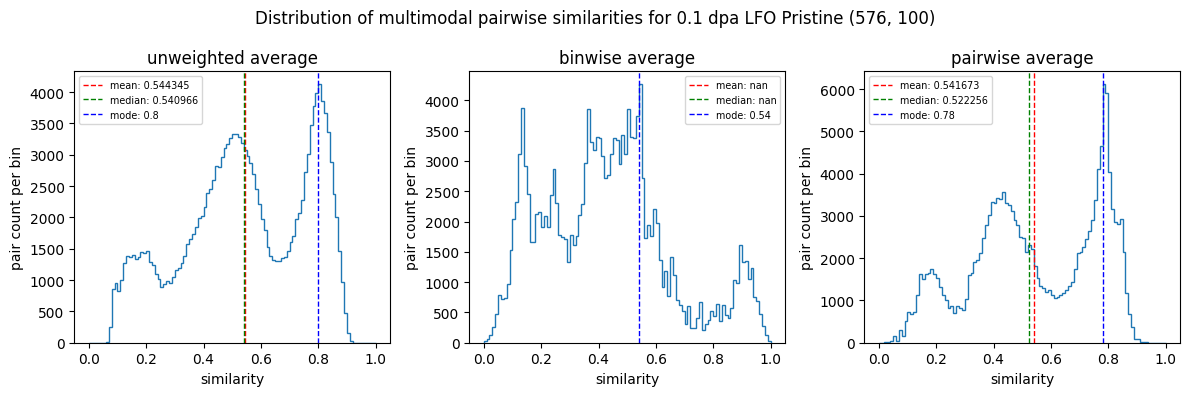

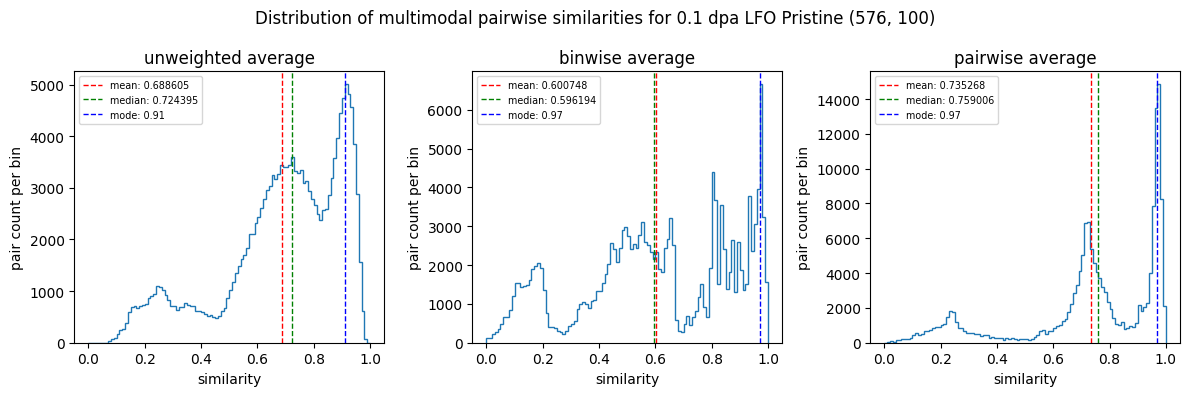

In [11]:
### must specify modality combinations currently cannot do all modality combinations ###
# specify modality combinations of interest and plot the similarity score distributions for each combination
combinations = ["image encoding data and eds spectra", "image encoding data and atom percent data"]
counts2 = {}
bins2 = {}
statistics2 = {}
for combo in combinations:
    num_rows, num_cols = (1, 3)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4))
    title = "Distribution of multimodal pairwise similarities for " + name + " (" + str(data.shape[0]) + ", " + str(num_bins) + ")"
    fig.suptitle(title)
    coordinates = np.arange(num_cols)
    _ = 0
    counts2[combo] = {}
    bins2[combo] = {}
    statistics2[combo] = {}
    for n in similarities2[combo].keys():
        axs[coordinates[_]].set_title(n)

        c, b = np.histogram(similarities2[combo][n], bins=np.arange(0, 1 + (1 / num_bins), 1 / num_bins))

        mean = np.mean(similarities2[combo][n])
        median = np.median(similarities2[combo][n])
        mode = b[np.argmax(c)]

        rounded_mean = np.round(mean, decimals=6)
        rounded_median = np.round(median, decimals=6)
        rounded_mode = np.round(mode, decimals=6)

        counts2[combo][n] = c
        bins2[combo][n]  = b
        statistics2[combo][n] = {"mean": mean, "median": median, "mode": mode}

        axs[coordinates[_]].axvline(rounded_mean, color='r', linestyle='dashed', linewidth=1, label='mean: ' + str(rounded_mean))
        axs[coordinates[_]].axvline(rounded_median, color='g', linestyle='dashed', linewidth=1, label='median: ' + str(rounded_median))
        axs[coordinates[_]].axvline(rounded_mode, color='b', linestyle='dashed', linewidth=1, label='mode: ' + str(rounded_mode))

        axs[coordinates[_]].stairs(c, b)     
        axs[coordinates[_]].set_xlabel("similarity")
        axs[coordinates[_]].set_ylabel("pair count per bin")
        axs[coordinates[_]].legend(fontsize='x-small')

        _ += 1
    plt.tight_layout()
    fig.savefig(os.path.join(results_path, name + "_" + combo.replace(" ", "_") + "_avg_similarities_dist.png"))

## Computing Adjacencies ##
After analyzing the distributions of similarity scores, you can create adjacency matrices by applying a cutoff with one of the following metrics: `'mean'`, `'median'`, and `'mode'`. Similarity scores that are less than or equal to the cutoff will be filtered out from the corresponding adjacency matrix. This reduces the connectivity of the graph and allows us to use community detection methods to group communities of similar chips together.

In [12]:
# choose cutoff metric from "mean", "median", and "mode"
cutoff_metric = "mode"

In [13]:
# compute cutoff metrics for each modality
cutoffs = {}
for modality in modalities:
    if cutoff_metric == "mean":
        cutoffs[modality] = statistics[modality]["mean"]
    elif cutoff_metric == "median":
        cutoffs[modality] = statistics[modality]["median"]
    else:
        cutoffs[modality] = statistics[modality]["mode"]

# compute adjacency matrices by applying cutoff metrics to the matrix of similarity score values for each modality
dsqs = {}
adjacencies = {}
for modality in modalities:
    dsqs[modality] = squareform(similarities[modality]) 
    adjacencies[modality] = (dsqs[modality] > cutoffs[modality]).astype(int)

In [14]:
# compute cutoff metrics for each modality combination specified in combinations above
cutoffs2 = {}
for combo in combinations:
    cutoffs2[combo] = {}
    for n in statistics2[combo].keys():
        if cutoff_metric == "mean":
            cutoffs2[combo][n] = statistics2[combo][n]["mean"]
        elif cutoff_metric == "median":
            cutoffs2[combo][n] = statistics2[combo][n]["median"]
        else:
            cutoffs2[combo][n] = statistics2[combo][n]["mode"]

# compute adjacency matrices by applying cutoff metrics to the matrix of similarity score values for each modality 
# combination specified in combinations above
dsqs2 = {}
adjacencies2 = {}
for combo in combinations:
    dsqs2[combo] = {}
    adjacencies2[combo] = {}
    for n in similarities2[combo].keys():
        dsqs2[combo][n] = squareform(similarities2[combo][n]) 
        adjacencies2[combo][n] = (dsqs2[combo][n] > cutoffs2[combo][n]).astype(int)

## Create and Store Data in Graph Structure ##
Once the adjacency matrices are computed, graphs can be created to represent data from each modality or combination of modalities. The nodes of the graph represents chips and the edges are weighted by similarity scores.

In [15]:
# prepare graphs for each modality
graphs = {}
for modality in modalities:
    graphs[modality] = ig.Graph.Adjacency(adjacencies[modality], mode='undriected')

# prepare graphs for each modality combination specified in combinations above
graphs2 = {}
for combo in combinations:
    graphs2[combo] = {}
    for n in adjacencies2[combo].keys():
        graphs2[combo][n] = ig.Graph.Adjacency(adjacencies2[combo][n], mode='undriected')

## Use Louvain Community Detection to Partition Graphs into Communities of Similar Chips ##
The Louvain method for community detection is a community detection algorithm which extracts non-overlapping communities from large networks. The method attempts to optimize the modularity of the graph structure. 

In [16]:
# find partitions using the Louvain method for community detection on each unimodal graph
partitions = {}
for modality in modalities:
    partitions[modality] = louvain.find_partition(graphs[modality], louvain.ModularityVertexPartition, seed=42)

# find partitions using the Louvain method for community detection on each multimodal graph
partitions2 = {}
for combo in combinations:
    partitions2[combo] = {}
    for n in graphs2[combo].keys():
        partitions2[combo][n] = louvain.find_partition(graphs2[combo][n], louvain.ModularityVertexPartition, seed=42)

In [17]:
import re
memberships = {}
improvements = {}
for combo in combinations:
    modes = re.split(' and ', combo)
    membership, improvement = louvain.find_partition_multiplex([graphs[modes[0]], graphs[modes[1]]], louvain.ModularityVertexPartition)
    memberships[combo] = membership
    improvements[combo] = improvement

In [18]:
# store predictions made by Louvain community detection algorithm for each modality in dictionary
predictions = {}
for modality in modalities:
    predictions[modality] = {}
    for s in range(len(partitions[modality])):
        for node in partitions[modality][s]:
            predictions[modality][node] = s

# store predictions made by Louvain community detection algorithm for each modality combination in dictionary
predictions2 = {}
for combo in combinations:
    predictions2[combo] = {}
    for n in partitions2[combo].keys():
        predictions2[combo][n] = {}
        for s in range(len(partitions2[combo][n])):
            for node in partitions2[combo][n][s]:
                predictions2[combo][n][node] = s

In [19]:
predictions3 = {}
for combo in combinations:
    predictions3[combo] = {}
    for s in range(len(data['chip ID'])):
        predictions3[combo][s] = memberships[combo][s]

## Storing Results ##
Results from this approach are stored in dataframes.

In [20]:
# construct new pandas dataframes to store each modality's results seperately 
dfs = {}
for modality in modalities:
    dfs[modality] = pd.DataFrame({"chip ID": predictions[modality].keys(), modality + " prediction": predictions[modality].values()})
    dfs[modality] = dfs[modality].sort_values(by=['chip ID']).replace({"chip ID": inv_d})

# construct new pandas dataframes to store each combination's results seperately 
dfs2 = {}
for combo in combinations:
    dfs2[combo] = {}
    for n in predictions2[combo].keys():
        dfs2[combo][n] = pd.DataFrame({"chip ID": predictions2[combo][n].keys(), combo + " " + name + " " + n + " prediction": predictions2[combo][n].values()})
        dfs2[combo][n] = dfs2[combo][n].sort_values(by=['chip ID']).replace({"chip ID": inv_d})

In [21]:
# construct new pandas dataframes to store each combination's results seperately 
dfs3 = {}
for combo in combinations:
    dfs3[combo] = pd.DataFrame({"chip ID": predictions3[combo].keys(), combo + " prediction": predictions3[combo].values()})
    dfs3[combo] = dfs3[combo].sort_values(by=['chip ID']).replace({"chip ID": inv_d})

In [22]:
# merge dataframes into one large dataframe
ns = list(dfs.keys())
if len(ns) > 1:
    df = dfs[ns[0]].merge(dfs[ns[1]], left_on="chip ID", right_on="chip ID")
if len(ns) > 2:
    for n in ns[2:]:
        df = df.merge(dfs[n], left_on="chip ID", right_on="chip ID")
else:
    df = dfs[ns[0]]
df.to_csv(os.path.join(results_path, cutoff_metric + "_unimodal_predictions.csv"))

In [23]:
df

,chip ID,atom percent data prediction,eds spectra prediction,image data prediction,image encoding data prediction
0,R0C0,2,2,3,2
1,R0C1,2,2,3,2
2,R0C2,2,2,3,2
3,R0C3,2,2,3,2
4,R0C4,13,2,0,2
...,...,...,...,...,...
571,R23C19,1,1,2,0
572,R23C20,1,1,1,0
573,R23C21,1,1,3,0
574,R23C22,1,1,2,0


In [24]:
# do same for each combination
for combo in combinations:
    ns = list(dfs2[combo].keys())
    if len(ns) > 1:
        df2 = dfs2[combo][ns[0]].merge(dfs2[combo][ns[1]], left_on="chip ID", right_on="chip ID")
    if len(ns) > 2:
        for n in ns[2:]:
            df2 = df2.merge(dfs2[combo][n], left_on="chip ID", right_on="chip ID")
    else:
        df2 = dfs2[ns[0]]
    df2.to_csv(os.path.join(results_path, combo.replace(" ", "_") + "_" + cutoff_metric + "_multimodal_predictions.csv"))

In [25]:
df2

,chip ID,image encoding data and atom percent data 0.1 dpa LFO Pristine unweighted average prediction,image encoding data and atom percent data 0.1 dpa LFO Pristine binwise average prediction,image encoding data and atom percent data 0.1 dpa LFO Pristine pairwise average prediction
0,R0C0,2,2,2
1,R0C1,2,6,2
2,R0C2,2,2,2
3,R0C3,2,7,2
4,R0C4,2,8,8
...,...,...,...,...
571,R23C19,1,1,1
572,R23C20,1,1,1
573,R23C21,1,1,1
574,R23C22,1,1,1


In [26]:
# merge dataframes into one large dataframe
ns = list(dfs3.keys())
df3 = dfs3[ns[0]].merge(dfs3[ns[1]], left_on="chip ID", right_on="chip ID")
df3.to_csv(os.path.join(results_path, cutoff_metric + "_multiplex_predictions.csv"))

In [27]:
df3

,chip ID,image encoding data and eds spectra prediction,image encoding data and atom percent data prediction
0,R0C0,2,2
1,R0C1,2,2
2,R0C2,2,2
3,R0C3,2,2
4,R0C4,2,2
...,...,...,...
571,R23C19,1,1
572,R23C20,1,1
573,R23C21,1,1
574,R23C22,1,1
